In [0]:
from keras import backend as K
import time
import matplotlib.pyplot as plt
import numpy as np
% matplotlib inline
np.random.seed(2017) 
from keras.models import Sequential, Model
from keras.layers.convolutional import Convolution2D, MaxPooling2D, SeparableConv2D
from keras.layers import Activation, Flatten, Dense, Dropout
from keras.layers.normalization import BatchNormalization
from keras.utils import np_utils
from keras.layers import Conv2D, Input
import keras


from keras.callbacks import LearningRateScheduler, EarlyStopping, ModelCheckpoint, ReduceLROnPlateau


In [2]:
from keras.datasets import cifar10
(train_features, train_labels), (test_features, test_labels) = cifar10.load_data()
num_train, img_channels, img_rows, img_cols =  train_features.shape
num_test, _, _, _ =  test_features.shape
num_classes = len(np.unique(train_labels))

170500096/170498071 [==============================] - 6s 0us/step


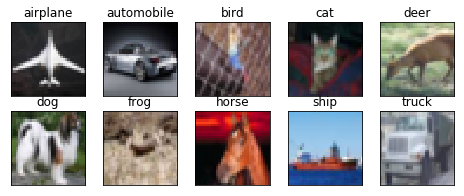

In [3]:
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']
fig = plt.figure(figsize=(8,3))
for i in range(num_classes):
    ax = fig.add_subplot(2, 5, 1 + i, xticks=[], yticks=[])
    idx = np.where(train_labels[:]==i)[0]
    features_idx = train_features[idx,::]
    img_num = np.random.randint(features_idx.shape[0])
    im = features_idx[img_num]
    ax.set_title(class_names[i])
    plt.imshow(im)
plt.show()

In [0]:
def plot_model_history(model_history):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    # summarize history for accuracy
    axs[0].plot(range(1,len(model_history.history['acc'])+1),model_history.history['acc'])
    axs[0].plot(range(1,len(model_history.history['val_acc'])+1),model_history.history['val_acc'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history['acc'])+1),len(model_history.history['acc'])/10)
    axs[0].legend(['train', 'val'], loc='best')
    # summarize history for loss
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()

In [0]:
def accuracy(test_x, test_y, model):
    result = model.predict(test_x)
    predicted_class = np.argmax(result, axis=1)
    true_class = np.argmax(test_y, axis=1)
    num_correct = np.sum(predicted_class == true_class) 
    accuracy = float(num_correct)/result.shape[0]
    return (accuracy * 100)

In [0]:
train_features = train_features.astype('float32')/255
test_features = test_features.astype('float32')/255
# convert class labels to binary class labels
train_labels = np_utils.to_categorical(train_labels, num_classes)
test_labels = np_utils.to_categorical(test_labels, num_classes)

## Added L2 regularization

In [0]:
import keras.backend as K
def loss_with_reg(model, batch_size, _lambda = 0.001):
  reg_loss_sqr = 0
  for layer in model.layers:
    if len(layer.get_weights()) > 0:
      reg_loss_sqr += np.sum(layer.get_weights()[0]**2)
  reg_loss_sqr = reg_loss_sqr * (_lambda/2*batch_size)
    
  def temp(y_true,y_pred):
    return K.categorical_crossentropy(y_true, y_pred)+reg_loss_sqr
  return temp

## In the following code I have implemented :

- Normal Convolution
- Spatially Separable Convolution  (Conv2d(x, (3,1)) followed by Conv2D(x,(3,1))
- Depthwise Separable Convolution
- Grouped Convolution (3x3 and 5x5)
- Grouped Convolution (one with 3x3,dilation = 1 and another with dilation = 2)

In [12]:
batch_size = 400

input_img = Input(shape=(32, 32, 3))

####################### 3x3 kernel ################################

x = Conv2D(48, (3, 3), border_mode = "same")(input_img)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Dropout(0.1)(x)

####################### 3x3 kernel ################################

############## Spacially Seperable Convolution#####################

x = Convolution2D(48, 3, 1)(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Dropout(0.1)(x)

x = Convolution2D(48, 1, 3)(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Dropout(0.1)(x)

############## Spacially Seperable Convolution ####################

####################### 3x3 kernel ################################

x = Conv2D(64, (3, 3), border_mode = "same")(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Dropout(0.1)(x)

####################### 3x3 kernel ################################

####################### Max-Pooling ###############################

x = MaxPooling2D(pool_size=(2, 2))(x)#13

####################### Max-Pooling ###############################

####################### 1x1 kernel ################################

x = Conv2D(48, (1, 1))(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)

####################### 1x1 kernel ################################

############### Depthwise Separable Convolution ###################

x = SeparableConv2D(64, 3)(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Dropout(0.1)(x)

############### Depthwise Separable Convolution ###################

####################### Max-Pooling ###############################

x = MaxPooling2D(pool_size=(2, 2))(x)#13

####################### Max-Pooling ###############################

####################### 1x1 kernel ################################

x = Conv2D(64, (1, 1))(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)

####################### 1x1 kernel ################################

############## Grouped Convolution (3x3 and 5x5) ##################

tower_3x3 = Conv2D(64, (3, 3), padding='same', activation='relu', name = "1_tower3x3")(x)
tower_5x5 = Conv2D(64, (5, 5), padding='same', activation='relu', name = "tower5x5")(x)
x = keras.layers.concatenate([tower_3x3, tower_5x5], axis=3)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Dropout(0.1)(x)

############## Grouped Convolution (3x3 and 5x5) ##################

## Grouped Convolution (one with 3x3,dilation = 1 and another with dilation = 2) ##

tower_3x3 = Conv2D(64, (3, 3), padding='same', activation='relu', name = "2_tower3x3")(x)
dialated_tower_3x3 = Conv2D(64, (3, 3), padding='same', activation='relu', dilation_rate = 2, name = "dialated_tower_3x3")(x)
x = keras.layers.concatenate([tower_3x3, dialated_tower_3x3], axis=3)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Dropout(0.1)(x)

## Grouped Convolution (one with 3x3,dilation = 1 and another with dilation = 2) ##

####################### 3x3 kernel ################################

x = Conv2D(128, (3, 3), border_mode = "same")(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Dropout(0.1)(x)

####################### 3x3 kernel ################################

####################### 3x3 kernel ################################

x = Conv2D(10, (3, 3))(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Dropout(0.1)(x)

####################### 3x3 kernel ################################

####################### 4x4 kernel ################################

x = Conv2D(10, (4, 4))(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Dropout(0.1)(x)

####################### 4x4 kernel ################################

x = Flatten()(x)
output = Activation("softmax")(x)

model = Model(inputs=input_img, outputs=output)

model.compile(optimizer='adam', loss=loss_with_reg(model,batch_size, _lambda = 0.0025), metrics=['accuracy'])

model.summary()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(48, (3, 3), padding="same")`
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(48, (3, 1))`
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(48, (1, 3))`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:30: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), padding="same")`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:98: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(128, (3, 3), padding="same")`


Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
conv2d_15 (Conv2D)              (None, 32, 32, 48)   1344        input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization_18 (BatchNo (None, 32, 32, 48)   192         conv2d_15[0][0]                  
__________________________________________________________________________________________________
activation_19 (Activation)      (None, 32, 32, 48)   0           batch_normalization_18[0][0]     
____________________________________________________________________________________________

## Here i have got an accuracy of 84.44% in 50 epocs. 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras_pre..., validation_data=(array([[[..., verbose=1, callbacks=[<keras.ca..., steps_per_epoch=125, epochs=50)`
  from ipykernel import kernelapp as app


Epoch 1/50


/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:716: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:724: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '



Epoch 00001: LearningRateScheduler setting learning rate to 0.003.
125/125 [==============================] - 42s 337ms/step - loss: 761.9649 - acc: 0.4170 - val_loss: 762.0832 - val_acc: 0.3986
Epoch 2/50

Epoch 00002: LearningRateScheduler setting learning rate to 0.0024610336.
125/125 [==============================] - 38s 305ms/step - loss: 761.5396 - acc: 0.5780 - val_loss: 761.6466 - val_acc: 0.5344
Epoch 3/50

Epoch 00003: LearningRateScheduler setting learning rate to 0.0020862309.
125/125 [==============================] - 38s 305ms/step - loss: 761.3355 - acc: 0.6464 - val_loss: 761.3921 - val_acc: 0.6283
Epoch 4/50

Epoch 00004: LearningRateScheduler setting learning rate to 0.0018105009.
125/125 [==============================] - 38s 306ms/step - loss: 761.2113 - acc: 0.6881 - val_loss: 761.0947 - val_acc: 0.7315
Epoch 5/50

Epoch 00005: LearningRateScheduler setting learning rate to 0.0015991471.
125/125 [==============================] - 38s 306ms/step - loss: 761.1356 -

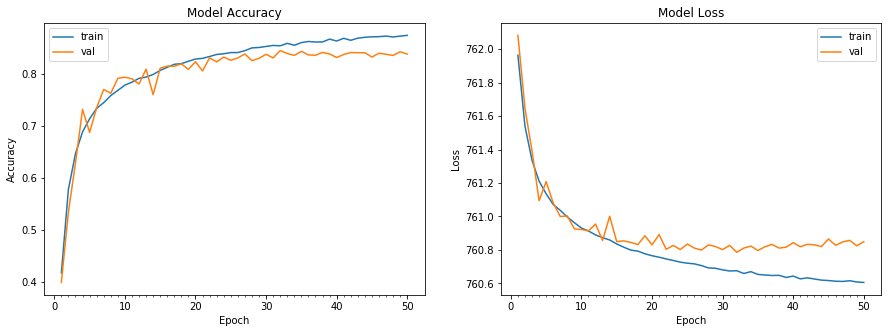

Accuracy on test data is: 83.76


In [13]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(featurewise_center=True,
                             featurewise_std_normalization=True,
                             zoom_range=0.0, 
                             horizontal_flip=True)

def scheduler(epoch, lr):
  return round(0.003 * 1/(1 + 0.219 * epoch), 10)
# train the model
start = time.time()
# Train the model
model_info = model.fit_generator(datagen.flow(train_features, train_labels, batch_size = batch_size),
                                 samples_per_epoch = train_features.shape[0], nb_epoch = 50, 
                                 validation_data = (test_features, test_labels), verbose=1, callbacks = [LearningRateScheduler(scheduler, verbose=1)])
end = time.time()
print ("Model took %0.2f seconds to train"%(end - start))
# plot model history
plot_model_history(model_info)
# compute test accuracy
print ("Accuracy on test data is: %0.2f"%accuracy(test_features, test_labels, model))#76 rf 40
